# compare 'unbiased' approaches for finding responsive areas

In [1]:
import glob
import os
# path for single animal
dPath = "/media/DATA/MAK/GRISZ_02/AA0001"
qFiles = glob.glob(os.path.join(dPath,'*.qcamraw'))
qFiles

['/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0015.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0017.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0018.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0019.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0020.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0021.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0022.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0032.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0033.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0034.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0035.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0036.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0037.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0038.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0048.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0049.qcamraw',
 '/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0050.qcamraw

In [3]:
file = qFiles[10]
print(file)
frameRate = 20

/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0035.qcamraw


In [5]:
import lib.fileIngest as fileIngest
import lib.signalProcess as signalProcess
import numpy as np

# example for one qcam file
print(file)
filepath = os.path.join(dPath,file)
img,header = fileIngest.extract_qcamraw(filepath)
t = signalProcess.getTimeVec(img.shape[-1])
reshaped_data = img.reshape(-1,200)

baseline = (2.5,3)
sound_stim_start = 3 #s
stimulation_length = 0.1 #s

# Example: Define sound and baseline periods (adjust indices as needed)
sound_response_search_len = 3 #s
sound_period = np.where((t>=sound_stim_start+stimulation_length) & (t<=sound_stim_start+sound_response_search_len))[0]  # Adjust indices to match your sound window
baseline_period = np.where((t>=baseline[0]) & (t<baseline[-1]))[0]  # Adjust indices to match your baseline window



/media/DATA/MAK/GRISZ_02/AA0001/AA0001AAAA0035.qcamraw


## k-means

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import lib.signalProcess as signalProcess

# kmeans_input = reshaped_data
kmeans_input = signalProcess.butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(kmeans_input)

# Define number of clusters (adjust as needed)
n_clusters = 6

# Apply k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_data)

# Reshape labels to original image dimensions
print(f"img dim: {img.shape[:-1]}")
cluster_map = cluster_labels.reshape(*img.shape[:-1])

img dim: (130, 174)


In [8]:
#Compute mean fluorescence for each cluster during sound and baseline

cluster_responses = []
for cluster_id in range(n_clusters):
    cluster_mask = cluster_map == cluster_id
    mean_sound = img[cluster_mask, :][:, sound_period].mean()
    mean_baseline = img[cluster_mask, :][:, baseline_period].mean()
    cluster_responses.append((cluster_id, mean_sound - mean_baseline))

# Sort clusters by response strength
sorted_clusters = sorted(cluster_responses, key=lambda x: x[1], reverse=True)
print(f"Clusters sorted by response strength: {sorted_clusters}")

Clusters sorted by response strength: [(1, np.float64(-0.10578467749365217)), (4, np.float64(-0.40919971533932653)), (2, np.float64(-0.6801097976875781)), (3, np.float64(-1.2857617687971583)), (5, np.float64(-2.1545307578206803)), (0, np.float64(-3.101401914105736))]


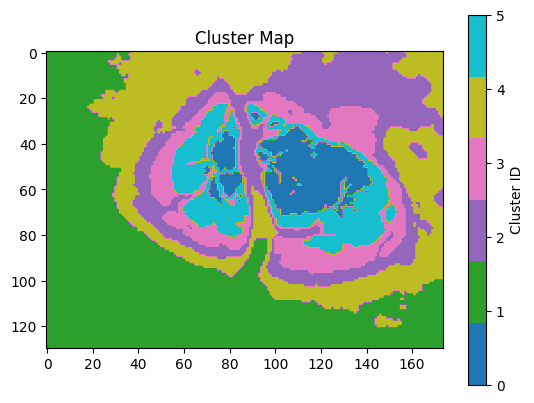

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.get_cmap('tab10')
new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, n_clusters))) # 5 colors instead of the default 256

plt.imshow(cluster_map, cmap=new_cmap)
plt.title("Cluster Map")
plt.colorbar(label="Cluster ID")
plt.show()

## gaussian mixture model

In [11]:
from sklearn.mixture import GaussianMixture

gmm_input = signalProcess.butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(gmm_input)

# Define the number of clusters
n_clusters = 6

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(normalized_data)

# Reshape labels to the original spatial dimensions (150x200)
cluster_map = gmm_labels.reshape(*img.shape[:-1])

/home/pac/Documents/Python/qcam/env/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [12]:
# Compute mean fluorescence for each cluster during sound and baseline

# Calculate response differences for each cluster
cluster_responses = []
for cluster_id in range(n_clusters):
    cluster_mask = cluster_map == cluster_id
    mean_sound = img[cluster_mask, :][:, sound_period].mean()
    mean_baseline = img[cluster_mask, :][:, baseline_period].mean()
    cluster_responses.append((cluster_id, mean_sound - mean_baseline))

# Sort clusters by response strength
sorted_clusters = sorted(cluster_responses, key=lambda x: x[1], reverse=True)
print(f"Clusters sorted by response strength: {sorted_clusters}")

Clusters sorted by response strength: [(1, np.float64(0.05529780564263298)), (4, np.float64(-0.103367603467035)), (2, np.float64(-0.42164943423293266)), (3, np.float64(-1.0380966682137966)), (5, np.float64(-1.8202411562349425)), (0, np.float64(-3.143945939118339))]


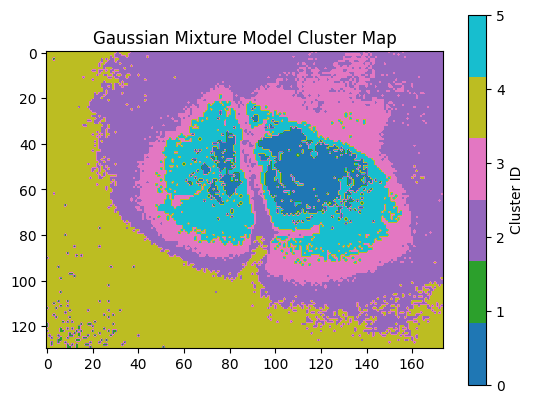

In [13]:
# Plot the cluster map
cmap = plt.get_cmap('tab10')
new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, n_clusters))) # 5 colors instead of the default 256

plt.imshow(cluster_map, cmap=new_cmap)
plt.title("Gaussian Mixture Model Cluster Map")
plt.colorbar(label="Cluster ID")
plt.show()

## PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_input = signalProcess.butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pca_input)

# Extract sound and baseline data
sound_data = normalized_data[:, sound_period]
baseline_data = normalized_data[:, baseline_period]

n_pca_components = 6
# Apply PCA to the sound data
pca_sound = PCA(n_components=n_pca_components)  # Number of components to retain
pcs_sound = pca_sound.fit_transform(sound_data)

# Apply PCA to the baseline data | 5
pca_baseline = PCA(n_components=n_pca_components)
pcs_baseline = pca_baseline.fit_transform(baseline_data)

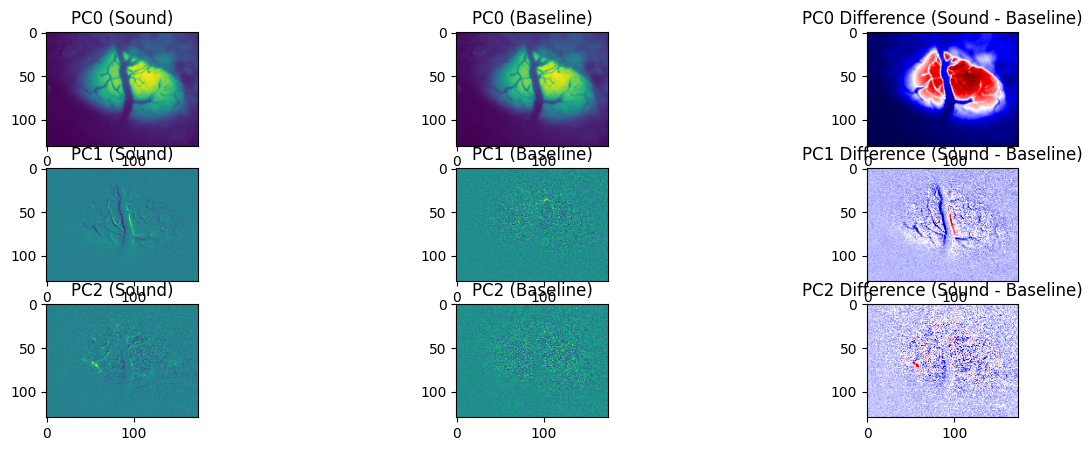

In [15]:
# select principal component (0: first, 1: second, etc)
# PC_sel = 1
#FIGURE
nPC = 3
fig,ax = plt.subplots(nPC,3,figsize=(15, 5))

for PC_sel in np.arange(nPC):
    # Get the principal component for visualization
    pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
    pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

    # Reshape PC back to spatial dimensions for visualization
    pc_sound_map = pc_sound.reshape(*img.shape[:2])
    pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

    # Calculate the difference between sound and baseline PCs
    pc_diff_map = pc_sound_map - pc_baseline_map

    # Sound PC2
    # plt.subplot(PC_sel+1, 3, 1)
    ax[PC_sel,0].imshow(pc_sound_map, cmap="viridis")
    ax[PC_sel,0].set_title(f"PC{PC_sel} (Sound)")
    # plt.colorbar()

    # Baseline PC1
    # plt.subplot(PC_sel+1, 3, 2)
    ax[PC_sel,1].imshow(pc_baseline_map, cmap="viridis")
    ax[PC_sel,1].set_title(f"PC{PC_sel} (Baseline)")
    # plt.colorbar()

    # Difference
    # plt.subplot(PC_sel+1, 3, 3)
    ax[PC_sel,2].imshow(pc_diff_map, cmap="seismic")
    ax[PC_sel,2].set_title(f"PC{PC_sel} Difference (Sound - Baseline)")
    # plt.colorbar()

plt.show()

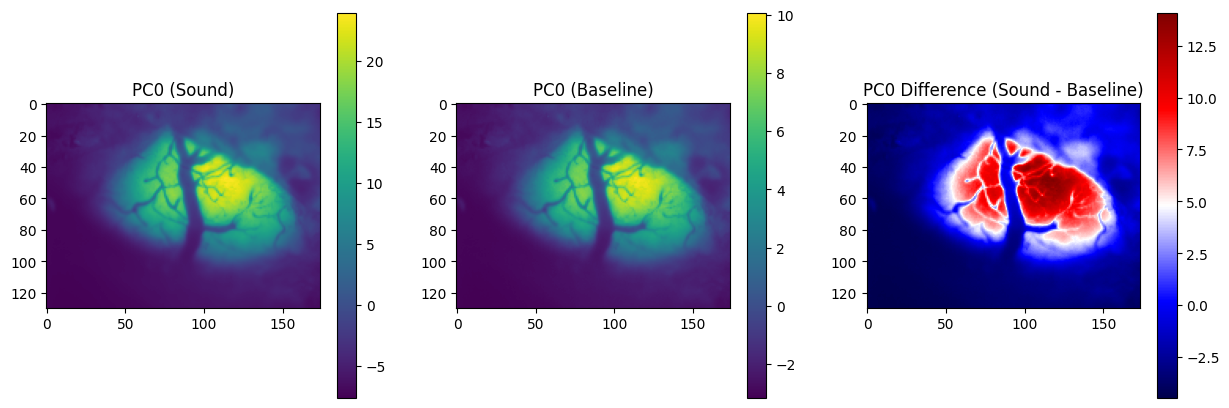

In [16]:
# select principal component (0: first, 1: second, etc)
PC_sel = 0

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

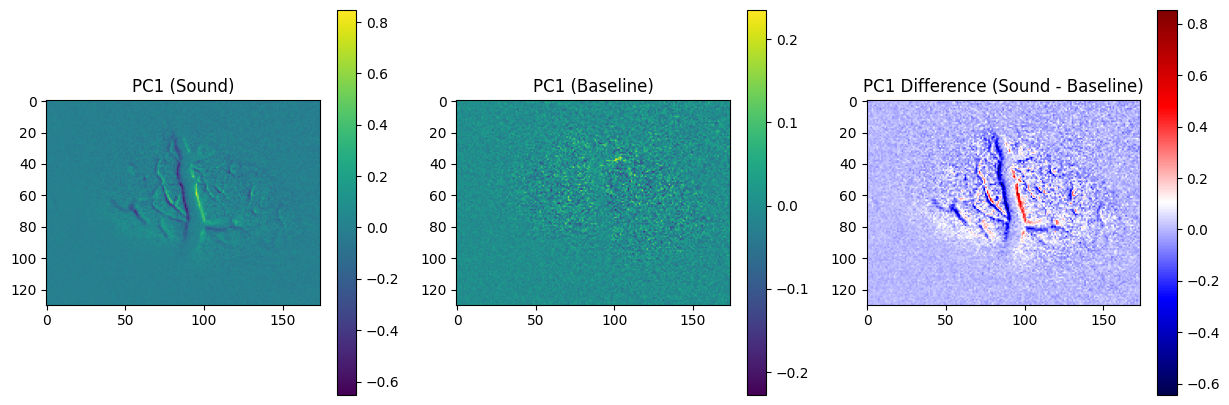

In [17]:
# select principal component (0: first, 1: second, etc)
PC_sel = 1

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

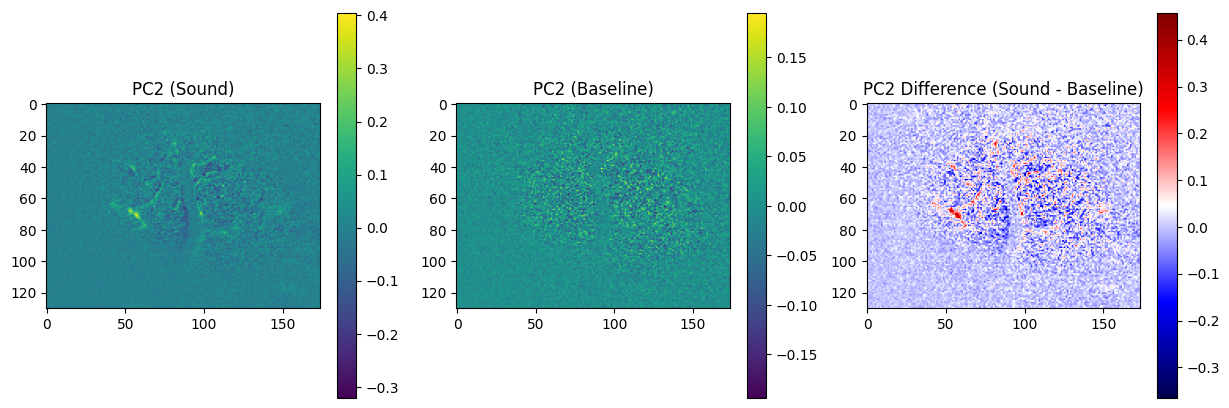

In [18]:
# select principal component (0: first, 1: second, etc)
PC_sel = 2

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

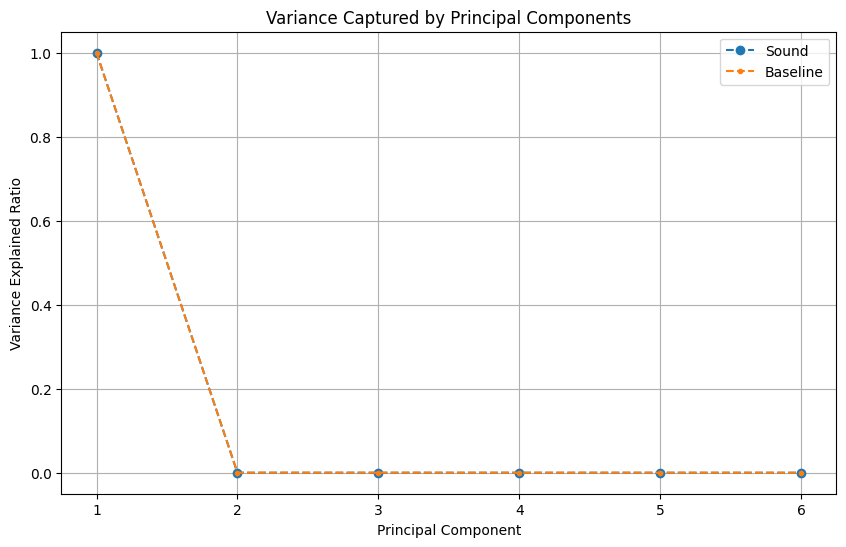

In [19]:
# Variance explained by each component for sound data
variance_explained_sound = pca_sound.explained_variance_ratio_

# Variance explained by each component for baseline data
variance_explained_baseline = pca_baseline.explained_variance_ratio_

# Plot variance explained
plt.figure(figsize=(10, 6))

# Sound data variance
plt.plot(
    range(1, len(variance_explained_sound) + 1),
    variance_explained_sound,
    marker="o",
    label="Sound",
    linestyle="--",
)

# Baseline data variance
plt.plot(
    range(1, len(variance_explained_baseline) + 1),
    variance_explained_baseline,
    marker=".",
    label="Baseline",
    linestyle="--",
)

plt.title("Variance Captured by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained Ratio")
plt.xticks(range(1, len(variance_explained_sound) + 1))
plt.legend()
plt.grid(True)
plt.show()